In [3]:
'''
as part of MS4 green infrastructure equity work and following this guidance from MA: 
https://www.mass.gov/doc/2016-massachusetts-small-ms4-permit-pollutant-loading-export-rates/download

generating PLER values for each land cover area in each municipality

created: 5/2/2023
author: rbowers

'''

import os
os.environ['USE_PYGEOS'] = '0'
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import sys
sys.path.append("..")
import statsmodels.api as sm
from statsmodels.formula.api import ols 
from rasterstats import zonal_stats
import contextily as cx
#import osmnx as ox
from affine import Affine
import rioxarray as rx
from multiprocessing import Pool, cpu_count
from shapely.ops import unary_union
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict
from pathlib import Path
import geopandas as gpd

import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import rioxarray as rxr
import xarray as xr 
from numpy import int16
from shapely.geometry import mapping


#see all columns in tables
pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 2

In [4]:
from src.features.build_features import *

In [5]:
muni = 'Natick'

print('Starting on municipality: ', muni)

#read in municipalities, select the one of interest
#municipalities
munis_fp = "K:\\\DataServices\\Datasets\\Boundaries\\Spatial\\mapc_towns_poly.shp"
munis = gpd.read_file(munis_fp)


#select just the muni 
muni_shp = munis.loc[munis['municipal'] == muni]

print('Reading in Land Cover/Land Use Data...')
#land use geodatabase location
lclu_gdb = "K:\\DataServices\\Datasets\\Zoning and Land Use\\Spatial\\lclu_gdb\\MA_LCLU2016.gdb"
lclu = gpd.read_file(lclu_gdb, layer="LANDCOVER_LANDUSE_POLY", mask=muni_shp)

print('Reading in Soils Data...')

#soils geodabatse location
ms4_gdb = 'K:\\DataServices\\Projects\\Current_Projects\\Environment\\MS4\\Project\\MS4_Tool_Preprocessing.gdb'
soils_hsg = gpd.read_file(ms4_gdb, layer="SOILS_MUPOLYGON_TOP20_MAPCclip", mask=muni_shp)

print('Reading in urban heat island Data...')
#bring in heat island raster so that we can build our dataset off of it 
heat_fp = 'K:\\DataServices\\Projects\\Current_Projects\\Climate_Change\\MVP_MMC_Heat_MVP\\00 Task 2 Deliverables\\2.1 Attachments\\00 Uploaded to Sharepoint\\Shapefile_LSTIndex\\LSTindex.tif'

#masking raster by muni
#https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/crop-raster-data-with-shapefile-in-python/
heat = rxr.open_rasterio(heat_fp,masked=True).squeeze()
heat_muni = heat.rio.clip(muni_shp.geometry.apply(mapping),muni_shp.crs)


#reproject all to mass mainland
mass_mainland_crs = "EPSG:26986"
lclu = lclu.to_crs(mass_mainland_crs)
muni_shp = muni_shp.to_crs(mass_mainland_crs)
soils_hsg = soils_hsg.to_crs(mass_mainland_crs)


Starting on municipality:  Natick
Reading in Land Cover/Land Use Data...
Reading in Soils Data...
Reading in urban heat island Data...


In [6]:
folder_path = "K:\\DataServices\\Projects\\Current_Projects\\Environment\\MS4\\Data\\Spatial\\Intermediate"
path = os.path.join(folder_path, muni) #make a subdirectory in intermediate folder w town name
os.makedirs(path, exist_ok=True)

path_to_tif_file = path + '\\heat_clipped_' + muni + '.tif'

# Write the data to a new geotiff file
heat_muni.rio.to_raster(path_to_tif_file, driver='GTiff')
clipped_heat = rasterio.open(path_to_tif_file)


(208049.32812945597, 216251.28655752522, 888602.1182976093, 897997.0888606705)

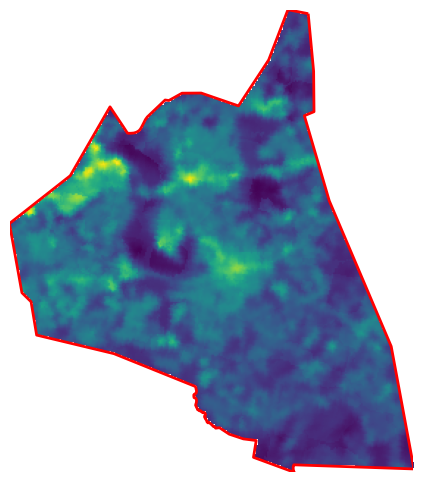

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))
p1 = muni_shp.plot(color=None,facecolor='none',edgecolor='red',linewidth = 2,ax=ax)
show(clipped_heat, ax=ax)
ax.axis('off')

In [43]:
soils_hsg['COMPNAME'].unique()

component_rule = [
    (soils_hsg['COMPNAME'] == 'Rock outcrop'),
    ((soils_hsg['COMPNAME'] == 'Udorthents') | (soils_hsg['COMPNAME'] == 'Urban land')),
    ((soils_hsg['COMPNAME'] != 'Rock outcrop') &(soils_hsg['COMPNAME'] != 'Udorthents') & (soils_hsg['COMPNAME'] != 'Urban land'))
    ]

choices = [1, 2, -1]
soils_hsg['comp_code'] = np.select(component_rule, choices, default=np.nan).astype(np.float32)



In [30]:
#create a coded field for rock outcrop and hydrologic soil group so it can be converted to a raster


hsg_rule = [
    (soils_hsg['HYDROLGRP'] == 'A'),
    (soils_hsg['HYDROLGRP'] == 'B'),
    (soils_hsg['HYDROLGRP'] == 'C'),
    (soils_hsg['HYDROLGRP'] == 'D'),
    (soils_hsg['HYDROLGRP'] == 'A/D'),
    (soils_hsg['HYDROLGRP'] == 'B/D'),
    (soils_hsg['HYDROLGRP'] == 'C/D'),
    (soils_hsg['HYDROLGRP'] == ' ')
]

choices = [1, 2, 3, 4, 5, 6, 7, -1]

soils_hsg['hsg_code'] = np.select(hsg_rule, choices, default=np.nan).astype(np.float32)
soils_hsg[['HYDROLGRP', 'hsg_code']].head()

,HYDROLGRP,hsg_code
0,B,2.0
1,,-1.0
2,A,1.0
3,B/D,6.0
4,A,1.0


In [44]:
#rasterize land cover
from rasterio import transform
from rasterio import features

#vectorize rasters
polys_to_rasterize = [lclu, soils_hsg]
                                    
# Rasterize vector using the shape and transform of the raster
rasterized_landcover = rasterize_geom(lclu, 'COVERCODE', clipped_heat)
rasterized_hsg = rasterize_geom(soils_hsg, 'hsg_code', clipped_heat)
rasterized_landuse = rasterize_geom(lclu, 'USEGENCODE', clipped_heat)
rasterized_soilcomp = rasterize_geom(soils_hsg, 'comp_code', clipped_heat)

(-0.5, 274.5, 314.5, -0.5)

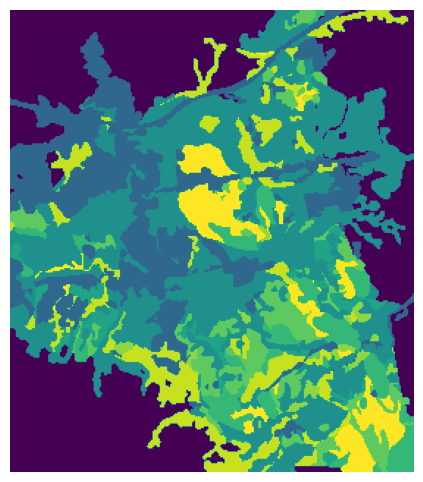

In [33]:
fig, ax = plt.subplots(figsize=(8, 6))
p1 = muni_shp.plot(color=None,facecolor='none',edgecolor='red',linewidth = 2,ax=ax)
show(rasterized_hsg, ax=ax)
ax.axis('off')

In [34]:
import copy

'''
driver = gdal.GetDriverByName('GTiff')
banda = rasterized_landcover.GetRasterBand(1)
landcover = banda.ReadAsArray()

bandb = rasterized_hsg.GetRasterBand(1)
hsg = bandb.ReadAsArray()

bandc = rasterized_landuse.GetRasterBand(1)
landuse = bandc.ReadAsArray()

'''
import numpy as np

landcover = rasterized_landcover
hsg = rasterized_hsg
landuse = rasterized_landuse
soilcomp = rasterized_soilcomp

list_dest = copy.copy(landcover)


# reclassification
list_dest[np.where(landcover== 21)] = 0

list_dest[np.where((landcover == 2) 
                   & ((landuse == 10) | (landuse == 12)))] = 2.32 

list_dest[np.where((landcover == 2) 
                   & ((landuse == 3) | (landuse==4) | (landuse==9) | (landuse==20) | (landuse==30))) ] = 1.78  
    
list_dest[np.where((landcover == 2) 
                   & (landuse == 55)) ] = 1.95       
 
list_dest[np.where((landcover == 2) 
                   & (landuse == 6)) ] = 1.52       

list_dest[np.where((landcover == 2) 
                   & (landuse == 7)) ] = 1.52     
    
list_dest[np.where((landcover == 2) 
                   & ((landuse == 0) | (landuse ==2) | (landuse==8))) ] = 1.52  
        
list_dest[np.where((landcover == 2) 
                   & ((landuse==13) | (landuse==11))) ] = 1.96       
   
list_dest[np.where((landcover != 2) 
                   & ((landcover == 9) | (landcover ==10) | (landcover==12))) ] = 0.13 
        
list_dest[np.where((landcover != 2) 
                   & (landcover == 6) 
                   & ((landcover==5) | (landcover==8) | (landcover==13) |(landcover==14)| (landcover==15) | (landcover==16) |(landcover==17)| (landcover==19) |(landcover==20))) ] = 0.13   
       
list_dest[np.where((landcover != 2) 
                   &  ((landcover == 1) | (landcover==5)))] = 0.45    
                                             
list_dest[np.where((landcover != 2) 
                   & (landcover == 5) 
                   & (landuse== 7))] = 0.45

list_dest[np.where((landcover != 2) 
                   & (landcover == 8) 
                   & (landuse== 7))] = 0.45

list_dest[np.where((landcover != 2) 
                   & ((landcover==5) | (landcover==8) | (landcover==13) |(landcover==14)| (landcover==15) | (landcover==16) |(landcover==17)| (landcover==18)| (landcover==19) |(landcover==20)) 
                   & ((hsg == 1) | (hsg == 5)))] = 0.03

list_dest[np.where((landcover != 2) 
                   & ((landcover==5) | (landcover==8) | (landcover==13) |(landcover==14)| (landcover==15) | (landcover==16) |(landcover==17)| (landcover==18)| (landcover==19) |(landcover==20)) 
                   & ((hsg == 2) | (hsg == 6)))] = 0.12

list_dest[np.where((landcover != 2) 
                   & ((landcover==5) | (landcover==8) | (landcover==13) |(landcover==14)| (landcover==15) | (landcover==16) |(landcover==17)| (landcover==18)| (landcover==19) |(landcover==20)) 
                   & ((hsg == 3) | (hsg == 7)))] = 0.21

list_dest[np.where((landcover != 2) 
                   & ((landcover==5) | (landcover==8) | (landcover==13) |(landcover==14)| (landcover==15) | (landcover==16) |(landcover==17)| (landcover==18)| (landcover==19) |(landcover==20)) 
                   & (hsg == 4))] = 0.37

list_dest[np.where((landcover != 2) 
                   & ((landcover==5) | (landcover==8) | (landcover==13) |(landcover==14)| (landcover==15) | (landcover==16) |(landcover==17)| (landcover==18)| (landcover==19) |(landcover==20)) 
                   & (hsg == -1)
                   & (soilcomp == 2))] = 0.21

list_dest[np.where((landcover != 2) 
                   & ((landcover==5) | (landcover==8) | (landcover==13) |(landcover==14)| (landcover==15) | (landcover==16) |(landcover==17)| (landcover==18)| (landcover==19) |(landcover==20)) 
                   & (hsg == -1)
                   & (soilcomp == 1)
                   & ((landuse == 10) | (landuse == 12)))] = 2.32

list_dest[np.where((landcover != 2) 
                   & ((landcover==5) | (landcover==8) | (landcover==13) |(landcover==14)| (landcover==15) | (landcover==16) |(landcover==17)| (landcover==18)| (landcover==19) |(landcover==20)) 
                   & (hsg == -1)
                   & (soilcomp == 1)
                   & ((landuse == 3) | (landuse==4) | (landuse==9) | (landuse==20) | (landuse==30))) ] = 1.78 

list_dest[np.where((landcover != 2) 
                   & ((landcover==5) | (landcover==8) | (landcover==13) |(landcover==14)| (landcover==15) | (landcover==16) |(landcover==17)| (landcover==18)| (landcover==19) |(landcover==20)) 
                   & (hsg == -1)
                   & (soilcomp == 1)
                   & (landuse == 55)) ] = 1.95  


list_dest[np.where((landcover != 2) 
                   & ((landcover==5) | (landcover==8) | (landcover==13) |(landcover==14)| (landcover==15) | (landcover==16) |(landcover==17)| (landcover==18)| (landcover==19) |(landcover==20)) 
                   & (hsg == -1)
                   & (soilcomp == 1)
                   & (landuse == 6)) ] = 1.52    

list_dest[np.where((landcover != 2) 
                   & ((landcover==5) | (landcover==8) | (landcover==13) |(landcover==14)| (landcover==15) | (landcover==16) |(landcover==17)| (landcover==18)| (landcover==19) |(landcover==20)) 
                   & (hsg == -1)
                   & (soilcomp == 1)
                   & (landuse == 7)) ] = 1.52       

list_dest[np.where((landcover != 2) 
                   & ((landcover==5) | (landcover==8) | (landcover==13) |(landcover==14)| (landcover==15) | (landcover==16) |(landcover==17)| (landcover==18)| (landcover==19) |(landcover==20)) 
                   & (hsg == -1)
                   & (soilcomp == 1)
                   & ((landuse == 0) | (landuse ==2) | (landuse==8))) ] = 1.52  

list_dest[np.where((landcover != 2) 
                   & ((landcover==5) | (landcover==8) | (landcover==13) |(landcover==14)| (landcover==15) | (landcover==16) |(landcover==17)| (landcover==18)| (landcover==19) |(landcover==20)) 
                   & (hsg == -1)
                   & (soilcomp == 1)
                   & ((landuse==13) | (landuse==11))) ] = 1.96 






In [36]:
list_dest

array([[-5.  , -5.  ,  1.95, ..., -5.  , -5.  , -5.  ],
       [-5.  , -5.  ,  1.95, ..., -5.  , -5.  , -5.  ],
       [-5.  , -5.  ,  1.95, ..., -5.  , -5.  , -5.  ],
       ...,
       [-5.  , -5.  , -5.  , ...,  0.13,  0.13,  0.13],
       [-5.  , -5.  , -5.  , ...,  0.13,  0.13,  0.13],
       [-5.  , -5.  , -5.  , ...,  1.95,  1.95,  0.13]], dtype=float32)

use_1_vals = ['Mixed use, primarily residential', 12]
use_2_vals = ['Commercial', 'Industrial', 'Tax exempt', 'Mixed use, other', 'Mixed use, primarily commercial'] 
use_3_vals = ['Right-of-way']
use_4_vals = ['Forest']
use_5_vals = ['Agriculture']
use_6_vals = ['Unknown', 'Open land', 'Recreation']
use_7_vals = ['Residential - other', 'Residential - single family']

cover_1_vals = ['Deciduous Forest', 'Evergreen Forest', 'Scrub/Shrub']
cover_2_vals = ['Developed Open Space', 'Grassland', 'Palustrine Forested Wetland', 
                'Palustrine Scrub/Shrub Wetland', 'Palustrine Emergent Wetland',
                'Estuarine Forested Wetland', 'Estuarine Scrub/Shrub Wetland', 'Estuarine Emergent Wetland'
                ]
cover_3_vals = ['Cultivated', 'Pasture/Hay']
cover_4_vals = ['Developed Open Space', 'Grassland', 'Palustrine Forested Wetland', 'Palustrine Scrub/Shrub Wetland',
                'Palustrine Emergent Wetland', 'Estuarine Emergent Wetland', 'Estuarine Forested Wetland', 'Estuarine Scrub/Shrub Wetland',
                'Unconsolidated Shore', 'Bare Land']

PLER_rule = [
    (lclu_with_soils['COVERNAME'] == 'Impervious') & lclu_with_soils['USEGENNAME'].isin(use_1_vals),
    (lclu_with_soils['COVERNAME'] == 'Impervious') & lclu_with_soils['USEGENNAME'].isin(use_2_vals),
    (lclu_with_soils['COVERNAME'] == 'Impervious') & lclu_with_soils['USEGENNAME'].isin(use_3_vals),
    (lclu_with_soils['COVERNAME'] == 'Impervious') & lclu_with_soils['USEGENNAME'].isin(use_4_vals),
    (lclu_with_soils['COVERNAME'] == 'Impervious') & lclu_with_soils['USEGENNAME'].isin(use_5_vals),
    (lclu_with_soils['COVERNAME'] == 'Impervious') & lclu_with_soils['USEGENNAME'].isin(use_6_vals),
    (lclu_with_soils['COVERNAME'] == 'Impervious') & lclu_with_soils['USEGENNAME'].isin(use_7_vals),
    (lclu_with_soils['COVERNAME'] != 'Impervious') &  lclu_with_soils['COVERNAME'].isin(cover_1_vals),
    (lclu_with_soils['COVERNAME'] != 'Impervious') & (lclu_with_soils['USEGENNAME'] == 'Forest') & lclu_with_soils['COVERNAME'].isin(cover_2_vals),
    (lclu_with_soils['COVERNAME'] != 'Impervious') &  lclu_with_soils['COVERNAME'].isin(cover_3_vals),
    (lclu_with_soils['COVERNAME'] != 'Impervious') & (lclu_with_soils['COVERNAME'] == 'Developed Open Space') & (lclu_with_soils['USEGENNAME']== 'Agriculture'),
    (lclu_with_soils['COVERNAME'] != 'Impervious') & (lclu_with_soils['COVERNAME'] == 'Grassland') & (lclu_with_soils['USEGENNAME']== 'Agriculture'),
    (lclu_with_soils['COVERNAME'] != 'Impervious') & (lclu_with_soils['COVERNAME'] == 'Pasture/Hay') & (lclu_with_soils['USEGENNAME']== 'Forest')
]

choices = [2.32, 1.78, 1.95, 1.52, 1.52, 1.52, 1.96, 0.13, 0.13, 0.45, 0.45, 0.45, 0.45]

lclu_with_soils['PLER'] = np.select(PLER_rule, choices, default=np.nan)
lclu_with_soils[['COVERNAME', 'USEGENNAME', 'PLER', 'acres']]



In [ ]:
lclu_with_soils.head()

,COVERNAME,COVERCODE,USEGENNAME,USEGENCODE,USE_CODE,POLY_TYPE,FY,TOWN_ID,TILENAME,Shape_Length_left,Shape_Area_left,geometry,HYDROLGRP_first,acres,PLER
0,Deciduous Forest,9,Residential - single family,11,101,FEE,2011,198,R08C17,85.497475,306.500000,"MULTIPOLYGON (((213945.267 897369.572, 213946....",A,0.007036,0.13
1,Deciduous Forest,9,Tax exempt,9,924,FEE,2011,198,R08C17,54.009296,56.815985,"MULTIPOLYGON (((213830.970 897369.885, 213830....",A,0.001304,0.13
2,Evergreen Forest,10,Right-of-way,55,000,ROW,2011,198,R08C17,64.219558,88.685490,"MULTIPOLYGON (((213821.037 897364.066, 213799....",A,0.002036,0.13
3,Evergreen Forest,10,Tax exempt,9,924,FEE,2011,198,R08C17,41.723008,81.968114,"MULTIPOLYGON (((213831.782 897373.392, 213831....",A,0.001882,0.13
4,Evergreen Forest,10,Unknown,0,000,NaN,0,0,R08C17,51.065457,3.890252,"MULTIPOLYGON (((213462.551 897379.408, 213454....",A,0.000089,0.13


In [ ]:
cover_4_vals = ['Developed Open Space', 'Grassland', 'Palustrine Forested Wetland', 'Palustrine Scrub/Shrub Wetland',
                'Palustrine Emergent Wetland', 'Estuarine Emergent Wetland', 'Estuarine Forested Wetland', 'Estuarine Scrub/Shrub Wetland',
                'Unconsolidated Shore', 'Bare Land']

#next add an hsg and 

In [ ]:
['Deciduous Forest' 'Evergreen Forest' 'Developed Open Space'
 'Palustrine Scrub/Shrub Wetland' 'Impervious'
 'Palustrine Forested Wetland' 'Palustrine Emergent Wetland' 'Grassland'
 'Bare Land' 'Scrub/Shrub' 'Water' 'Palustrine Aquatic Bed' 'Pasture/Hay'
 'Cultivated']

['Residential - single family' 'Tax exempt' 'Right-of-way' 'Unknown'
 'Open land' 'Water' 12 'Industrial'
 'Commercial' 'Recreation' 'Agriculture' 'Residential - other' 'Forest'
 'Mixed use, other' 'Mixed use, primarily residential']